In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import math
from statsmodels.tsa.arima_model import ARIMA
warnings.filterwarnings("ignore")   ##### ignore warnings 

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
# fix seed to make sure it is reproducible
np.random.seed(123)

# Rebuild ARIMA model

The ARCH/GARCH models will run over the based SARIMA(2,0,1) = ARMA(2,1) model from the "3.1-Model_ARMA_ARIMA_SARIMA" notebook, as it found the best performance between our tests

In [3]:
data = pd.read_csv('./data/dataset.csv', header=0, index_col=0, parse_dates=True, squeeze=True)

In [4]:
# Create Training and Test
train_data = data[:417]
test_data = data[417:]

In [5]:
# Let's fit this model
mod = ARIMA(train_data,order=(2,0,1))

results = mod.fit(trend='nc', disp=0)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Amount   No. Observations:                  417
Model:                     ARMA(2, 1)   Log Likelihood               -4004.164
Method:                       css-mle   S.D. of innovations           3560.925
Date:                Sun, 20 Jun 2021   AIC                           8016.328
Time:                        13:14:40   BIC                           8032.461
Sample:                             0   HQIC                          8022.706
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
ar.L1.Amount     0.6460      0.096      6.708      0.000       0.457       0.835
ar.L2.Amount     0.3444      0.096      3.586      0.000       0.156       0.533
ma.L1.Amount     0.5814      0.077      7.544      0.000       0.430       0.732
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0071           +0.0000j            1.0071            0.0000
AR.2           -2.8827           +0.0000j            2.8827            0.5000
MA.1           -1.7200           +0.0000j            1.7200            0.5000
-----------------------------------------------------------------------------
"""

# ARCH Models

## ARCH-LM Test on the SARIMA residuals

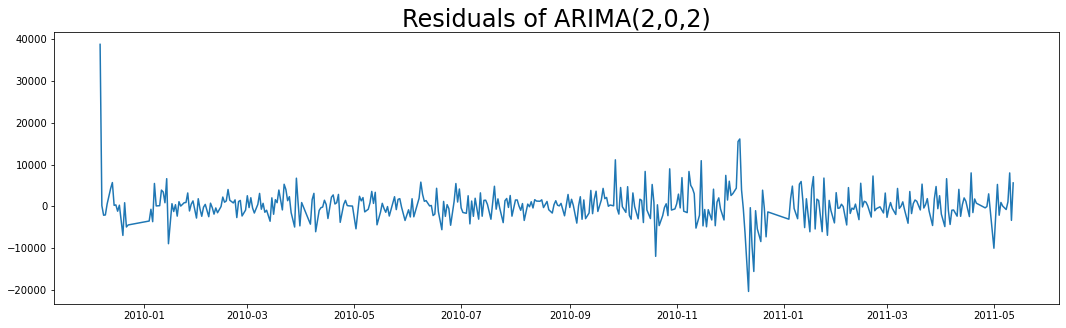

In [6]:
# Set the figure size
plt.rcParams["figure.figsize"] = 18, 5
# Plotting residuals
plt.plot(results.resid, label = "Residuals")
# Setting Title
plt.title("Residuals of ARIMA(2,0,2)", size = 24)
# Display the plot
plt.show()

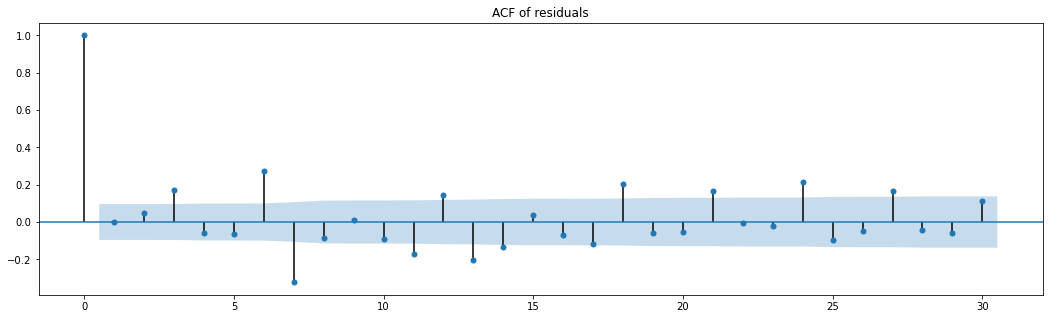

In [7]:
plot_acf(results.resid, lags=30, alpha=0.05, title="ACF of residuals")
plt.show()

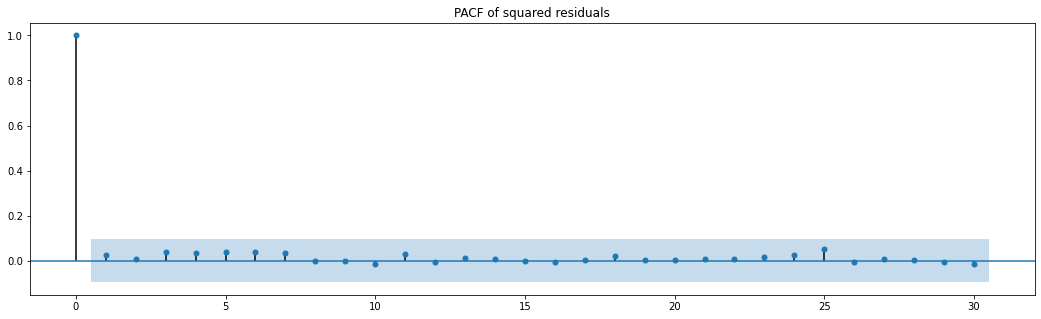

In [8]:
plot_pacf(results.resid**2, lags=30, alpha=0.05, title="PACF of squared residuals")
plt.show()

Now we will apply the LM-ARCH test in order to identify Heteroskedasticity on residuals

In [9]:
from statsmodels.stats.diagnostic import het_arch

arch_test = het_arch(results.resid, maxlag=50)

print(f'Lagrange mulitplier p-value: {arch_test[1]}')
print(f'F test p-value: {arch_test[3]}')

Lagrange mulitplier p-value: 1.7575072595121282e-07
F test p-value: 2.4725645902570004e-09


Both p-value are smaller than 0.05 we reject the null hypothesis that residuals are white noise, it points to heteroskedasticity. So we will check the ARCH and GARCH modelos

## ARCH model

As the ARCH-LM test has indicated that the variance in the series is autocorrelated, it makes sense to
apply the ARCH and GARCH models, and some of their variations, to our time series of smoothed log values.

In [10]:
# Importing required package
from arch import arch_model

resid_model_arch = arch_model(results.resid, p = 1, vol = "ARCH")
# Fitting (Training) the model
resid_model_arch_results = resid_model_arch.fit()
# Displaying the model summary
resid_model_arch_results.summary()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 4007.8177139313393
Iteration:      2,   Func. Count:     10,   Neg. LLF: 4000.8158888908515
Iteration:      3,   Func. Count:     14,   Neg. LLF: 4000.812430451392
Iteration:      4,   Func. Count:     18,   Neg. LLF: 4000.812358635265
Iteration:      5,   Func. Count:     22,   Neg. LLF: 4000.8123461851596
Iteration:      6,   Func. Count:     26,   Neg. LLF: 4000.8122749339136
Iteration:      7,   Func. Count:     30,   Neg. LLF: 4000.8119129534116
Iteration:      8,   Func. Count:     34,   Neg. LLF: 4000.810090168584
Iteration:      9,   Func. Count:     38,   Neg. LLF: 4000.801167812744
Iteration:     10,   Func. Count:     42,   Neg. LLF: 4000.7634029108954
Iteration:     11,   Func. Count:     46,   Neg. LLF: 4000.6848037101454
Iteration:     12,   Func. Count:     50,   Neg. LLF: 4000.683776884358
Iteration:     13,   Func. Count:     53,   Neg. LLF: 4000.683776884349
Optimization terminated successfully    (Exit mode 0)
   

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                   None   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                       ARCH   Log-Likelihood:               -4000.68
Distribution:                  Normal   AIC:                           8007.37
Method:            Maximum Likelihood   BIC:                           8019.47
                                        No. Observations:                  417
Date:                Sun, Jun 20 2021   Df Residuals:                      414
Time:                        13:14:55   Df Model:                            3
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu           200.2680    153.625      1.304      0.192 [-1.008e+02,5.014e+02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      8.8931e+06  1.202e+06      7.399  1.376e-13 [6.537e+06,1.125e+07]
alpha[1]       0.5155      0.228      2.259  2.386e-02   [6.831e-02,  0.963]
============================================================================

Covariance estimator: robust
"""

In [11]:
arch_bic = resid_model_arch_results.bic

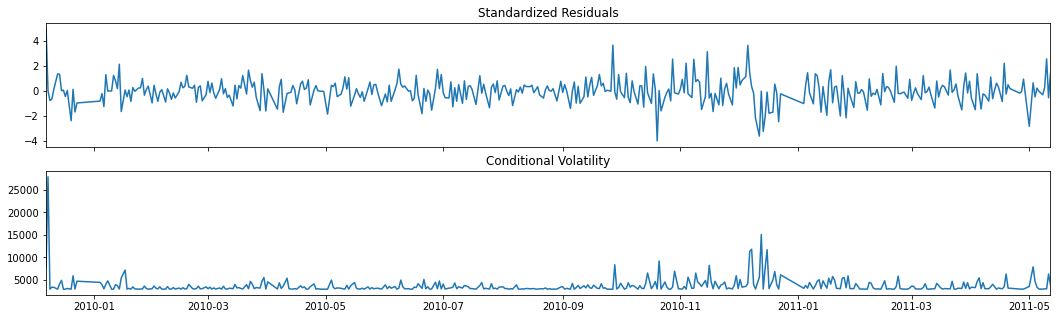

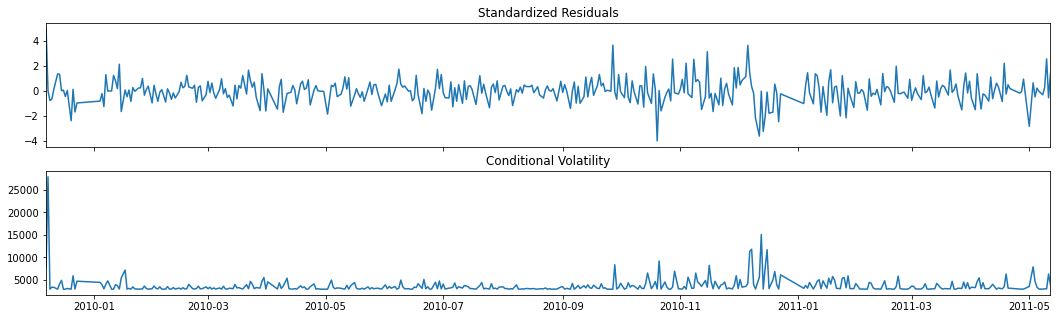

In [12]:
resid_model_arch_results.plot()

## GARCH model of order (1,1) with TStudents distribution

The GARCH(p,q) model is a generalization version of the ARCH. With a GARCH, it is possible to model the mean by including an ARMA order and also the variance (volatility), where p express the lags of conditional variance in the equation. A GARCH(0,q) model is equivalent to ARCH(q).

For the variance component, we have defined the order GARCH(1,1) as it is usually enough. Despite being a simple model, it is able to capture the most common scenarios regarding volatility (as heavy tails and clustering) and, historically, its predictions have a good performance.

In [13]:
# Importing required package
from arch import arch_model

resid_model_garch_Studentst = arch_model(results.resid, p = 1, q = 1 , vol = "GARCH", dist='StudentsT')
# Fitting (Training) the model
resid_model_garch_Studentst_results = resid_model_garch_Studentst.fit()
# Displaying the model summary
resid_model_garch_Studentst_results.summary()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 5000.889853446066
Iteration:      2,   Func. Count:     15,   Neg. LLF: 3959.3941061340233
Iteration:      3,   Func. Count:     22,   Neg. LLF: 4293.681026613056
Iteration:      4,   Func. Count:     29,   Neg. LLF: 3956.8287346057764
Iteration:      5,   Func. Count:     36,   Neg. LLF: 4299.269921021957
Iteration:      6,   Func. Count:     43,   Neg. LLF: 3956.2946096824244
Iteration:      7,   Func. Count:     49,   Neg. LLF: 3956.2907356947385
Iteration:      8,   Func. Count:     55,   Neg. LLF: 3956.290672195414
Iteration:      9,   Func. Count:     61,   Neg. LLF: 3956.290663951715
Iteration:     10,   Func. Count:     67,   Neg. LLF: 3956.290653668485
Iteration:     11,   Func. Count:     73,   Neg. LLF: 3956.2905881151783
Iteration:     12,   Func. Count:     79,   Neg. LLF: 3956.290438742737
Iteration:     13,   Func. Count:     85,   Neg. LLF: 3956.2900265510393
Iteration:     14,   Func. Count:     91,   Neg. LLF: 3956

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                         None   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                            GARCH   Log-Likelihood:               -3956.25
Distribution:      Standardized Student's t   AIC:                           7922.50
Method:                  Maximum Likelihood   BIC:                           7942.67
                                              No. Observations:                  417
Date:                      Sun, Jun 20 2021   Df Residuals:                      412
Time:                              13:15:02   Df Model:                            5
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu           241.6594    131.884      1.832  6.690e-02 [-16.828,5.001e+02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      3.2339e+05  1.414e+05      2.286  2.224e-02 [4.616e+04,6.006e+05]
alpha[1]       0.1060  3.338e-02      3.177  1.490e-03   [4.061e-02,  0.171]
beta[1]        0.8703  1.607e-02     54.164      0.000     [  0.839,  0.902]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             4.5426      0.949      4.784  1.715e-06 [  2.682,  6.403]
========================================================================

Covariance estimator: robust
"""

In [14]:
garch_T_bic = resid_model_garch_Studentst_results.bic

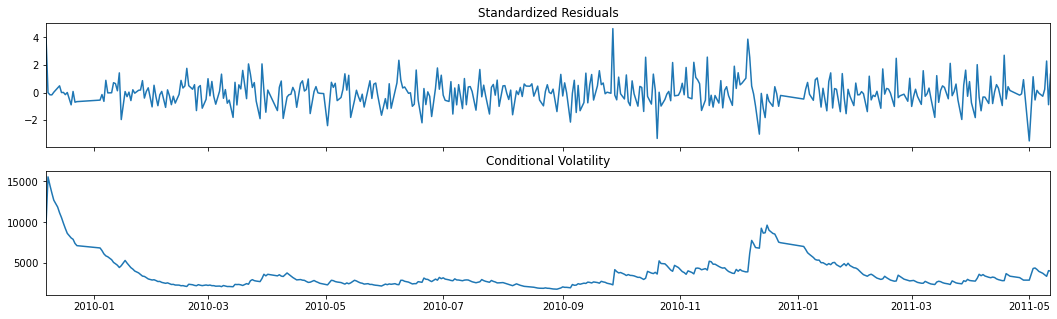

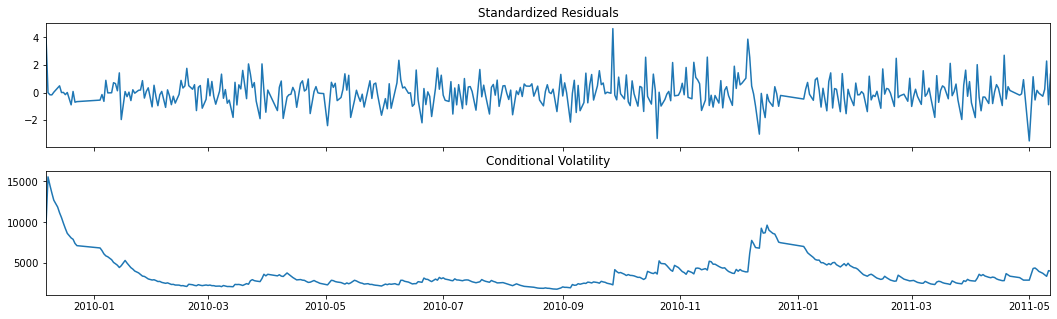

In [15]:
resid_model_garch_Studentst_results.plot()

## EGARCH model of order (1,1) with TStudents distribution

As GARCH always has an asymmetric response, due to the terms being squared based on its restrictions, it is not possible to distinguish between positive and negative shocks. This happening, the leverage impact of negative data will not be feasibly modelated. To accommodate this feature, the EGARCH model adds an asymmetry coefficient, which allows not only to keep the asymmetry but also to remove this restriction from the GARCH model.

In [16]:
# Importing required package
from arch import arch_model

resid_model_egarch_Studentst = arch_model(results.resid, p = 1, q = 1 , vol = "EGARCH", dist='StudentsT')
# Fitting (Training) the model
resid_model_egarch_Studentst_results = resid_model_egarch_Studentst.fit()
# Displaying the model summary
resid_model_egarch_Studentst_results.summary()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6581.80267075299
Iteration:      2,   Func. Count:     13,   Neg. LLF: 6588.657068571315
Iteration:      3,   Func. Count:     21,   Neg. LLF: 108252.96678124866
Iteration:      4,   Func. Count:     35,   Neg. LLF: 5934.99539581355
Iteration:      5,   Func. Count:     43,   Neg. LLF: 4070.334560123779
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3977.4796025992696
Iteration:      7,   Func. Count:     57,   Neg. LLF: 3971.75577964137
Iteration:      8,   Func. Count:     64,   Neg. LLF: 3970.362102161689
Iteration:      9,   Func. Count:     71,   Neg. LLF: 3969.2442258663996
Iteration:     10,   Func. Count:     78,   Neg. LLF: 3968.7295096747634
Iteration:     11,   Func. Count:     84,   Neg. LLF: 3968.6453579200693
Iteration:     12,   Func. Count:     90,   Neg. LLF: 3968.5546425779667
Iteration:     13,   Func. Count:     96,   Neg. LLF: 3968.3585914378605
Iteration:     14,   Func. Count:    102,   Neg. LLF: 3968.3

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - EGARCH Model Results                        
====================================================================================
Dep. Variable:                         None   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                           EGARCH   Log-Likelihood:               -3965.54
Distribution:      Standardized Student's t   AIC:                           7941.07
Method:                  Maximum Likelihood   BIC:                           7961.24
                                              No. Observations:                  417
Date:                      Sun, Jun 20 2021   Df Residuals:                      412
Time:                              13:15:08   Df Model:                            5
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu           204.9190    132.957      1.541      0.123 [-55.671,4.655e+02]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          7.3883      1.993      3.706  2.104e-04   [  3.481, 11.295]
alpha[1]       0.3155      0.145      2.183  2.904e-02 [3.223e-02,  0.599]
beta[1]        0.5535      0.119      4.664  3.095e-06   [  0.321,  0.786]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             3.3401      0.639      5.223  1.759e-07 [  2.087,  4.593]
========================================================================

Covariance estimator: robust
"""

In [17]:
egarch_T_bic = resid_model_egarch_Studentst_results.bic

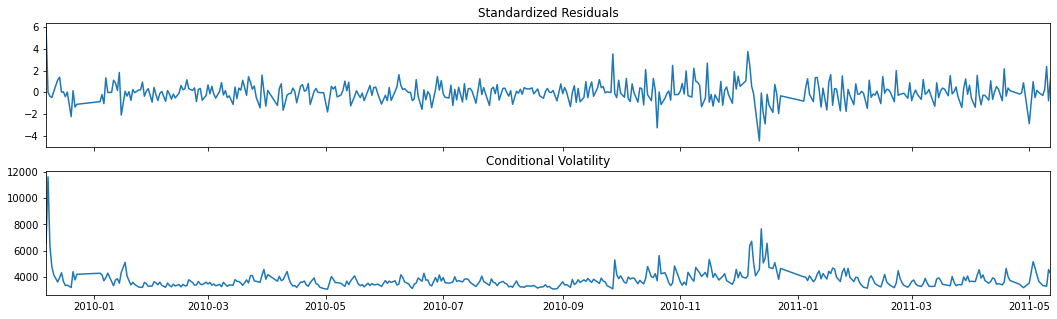

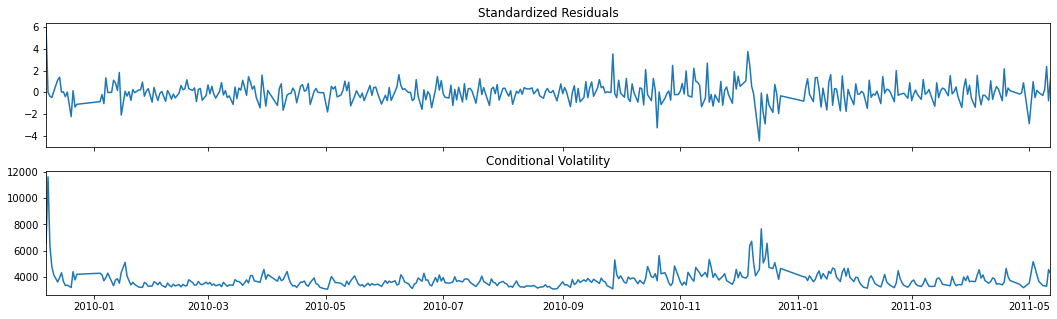

In [18]:
resid_model_egarch_Studentst_results.plot()

## GJR-GARCH model of order (1,1) with TStudents distribution

The GJR-GARCH assumes a dummy variable as an alternative to better model the negative and positive shocks. Basically, when the volatility is negative it assigns 1, otherwise 0. By doing this, negative shocks will cause more volatility than positive ones.

In [19]:
# Importing required package
from arch import arch_model

resid_model_gjrgarch_Studentst = arch_model(results.resid, p = 1, q = 1, o = 1 , vol = "GARCH", dist='StudentsT')
# Fitting (Training) the model
resid_model_gjrgarch_Studentst_results = resid_model_gjrgarch_Studentst.fit()
# Displaying the model summary
resid_model_gjrgarch_Studentst_results.summary()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 4998.951474539059
Iteration:      2,   Func. Count:     17,   Neg. LLF: 3981.2368199041593
Iteration:      3,   Func. Count:     25,   Neg. LLF: 3963.282637124342
Iteration:      4,   Func. Count:     33,   Neg. LLF: 4256.030748953557
Iteration:      5,   Func. Count:     41,   Neg. LLF: 3963.7307862832736
Iteration:      6,   Func. Count:     49,   Neg. LLF: 4272.929447825716
Iteration:      7,   Func. Count:     57,   Neg. LLF: 3955.8554750854114
Iteration:      8,   Func. Count:     64,   Neg. LLF: 3955.8117556063403
Iteration:      9,   Func. Count:     71,   Neg. LLF: 3955.8042147846854
Iteration:     10,   Func. Count:     78,   Neg. LLF: 3955.8022952571237
Iteration:     11,   Func. Count:     85,   Neg. LLF: 3955.802264850313
Iteration:     12,   Func. Count:     92,   Neg. LLF: 3955.802261994969
Iteration:     13,   Func. Count:     99,   Neg. LLF: 3955.802258171575
Iteration:     14,   Func. Count:    106,   Neg. LLF: 3955

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - GJR-GARCH Model Results                       
====================================================================================
Dep. Variable:                         None   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -3955.79
Distribution:      Standardized Student's t   AIC:                           7923.58
Method:                  Maximum Likelihood   BIC:                           7947.78
                                              No. Observations:                  417
Date:                      Sun, Jun 20 2021   Df Residuals:                      411
Time:                              13:15:15   Df Model:                            6
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu           257.0352    132.260      1.943  5.197e-02 [ -2.189,5.163e+02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      3.2339e+05  1.302e+05      2.483  1.301e-02 [6.817e+04,5.786e+05]
alpha[1]       0.1360  5.455e-02      2.493  1.267e-02   [2.907e-02,  0.243]
gamma[1]      -0.0675  7.790e-02     -0.867      0.386   [ -0.220,8.516e-02]
beta[1]        0.8706  1.528e-02     56.986      0.000     [  0.841,  0.900]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             4.7959      1.046      4.585  4.532e-06 [  2.746,  6.846]
========================================================================

Covariance estimator: robust
"""

In [20]:
gjrgarch_T_bic = resid_model_gjrgarch_Studentst_results.bic

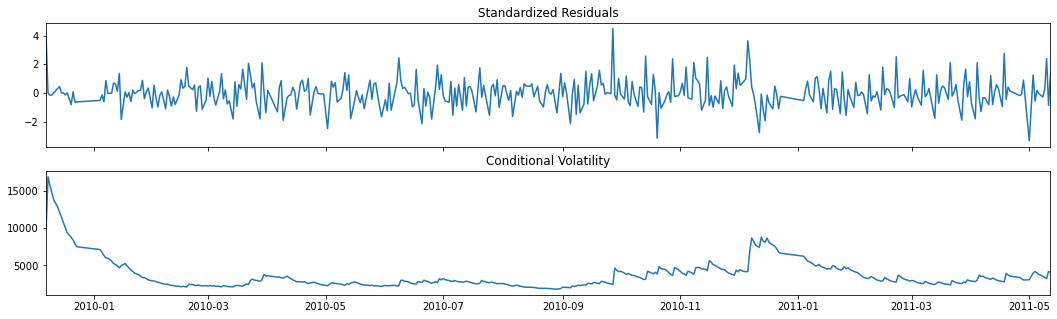

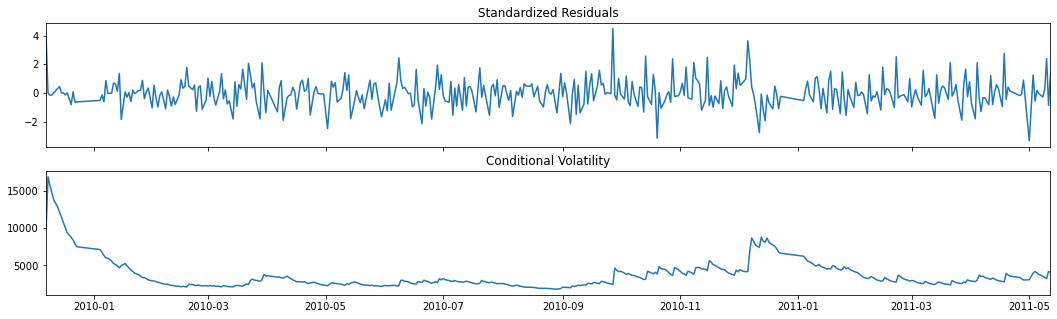

In [21]:
resid_model_gjrgarch_Studentst_results.plot()

## Comparison

In [22]:
#Compare bics and identify the smallest one
print("ARCH: ",arch_bic)
print("GARCH: ",garch_T_bic)
print("EGARCH: ",egarch_T_bic)
print("GJR-GARCH: ",gjrgarch_T_bic)

ARCH:  8019.466812434112
GARCH:  7942.665435048425
EGARCH:  7961.236737406059
GJR-GARCH:  7947.776862582234


Based on BIC the GARCH is the model that better explains the variance on residuals, although GARCH, EGARCH and GJR-GARCH had very similar results